In [3]:
import numpy as np
import pandas as pd
import itertools

def polynomialFeatures(X, degree):
    if degree <= 1:
        
        return X
    
    else:
        
        d = X.shape[1]
        int_terms = list(itertools.combinations(range(X.shape[1]), 2))
        for term in int_terms:
            X = np.c_[X, X[:, term[0]]*X[:, term[1]]]
    
        for i in range(1, degree):
            for j in range(d):
                X = np.c_[X, X[:, j]**(i+1)]
            
        return X

def mse(y_true, y_pred):
    return np.linalg.norm((y_true-y_pred), ord = 2)/len(y_pred)
# github check
def learning_curve(model, X, Y, cv, train_size=1, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs):
    size = train_size
    train_scores = []
    val_scores = []
    print(learning_rate)
    
    while size <= len(Y):
        partitions = k_partition(cv, X[:, :size], Y[:size])
        train_avg = []
        val_avg = []
        for i in range(cv):
            training_folds = np.concatenate([partitions[j] for j in range(len(partitions)) if j != i], axis = 0)
            test_fold = partitions[i]
            X_tr = training_folds[:, :(training_folds.shape[1]-1)]
            y_tr = training_folds[:, (training_folds.shape[1]-1)]
            X_val = test_fold[:, :(test_fold.shape[1]-1)]
            y_val = test_fold[:, (test_fold.shape[1]-1)]
                
            model.fit(X_tr, y_tr, learning_rate=learning_rate, epochs=epochs, tol=tol, regularizer=regularizer, lambd=lambd)
                
            y_train_pred = model.predict(X_tr)
            y_pred = model.predict(X_val)
            
            train_avg.append(np.sqrt(mse(y_tr, y_train_pred)))
            val_avg.append(np.sqrt(mse(y_val, y_pred)))
            
        train_scores.append(np.mean(train_avg))
        val_scores.append(np.mean(val_avg))
        
        size += train_size
        
    return train_scores, val_scores
        
    
class Linear_Regression:
    
    def __init__(self):
        pass
    
    def fit(self, X, Y, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs):
        m = X.shape[0]
        theta = np.random.randn(X.shape[1], 1)
        Y = np.reshape(Y, (Y.shape[0], 1))
        
        
        if tol is None:
            if regularizer is None:
                for i in range(epochs):
                    
                    prediction = X.dot(theta)
                    loss = prediction-Y
                    grad = X.T.dot(loss)
                    theta = theta - (learning_rate/m)*grad
                    
                self.theta = theta
                
            else:
                for i in range(epochs):
                
                    theta = theta - self.reg_cost_func(X, Y, regularizer, lambd, learning_rate, theta, m)
                
                self.theta = theta
                
        else:
            if regularizer is None:
                error = mse(Y, X.dot(theta))
                for i in range(epochs):
                
                    theta = theta - (1/m)*learning_rate*(X.T.dot((X.dot(theta)-Y)))
                    new_error = mse(Y, X.dot(theta))
                    
                    if new_error > (error - tol):
                        break
                    else:
                        error = new_error
                     
                self.theta = theta
                
            else:
                error = mse(Y, X.dot(theta))
                for i in range(epochs):
                
                    theta = theta - self.reg_cost_func(X, Y, regularizer, lambd, learning_rate, theta, m)
                    new_error = mse(Y, X.dot(theta))
                    
                    if new_error > (error - tol):
                        break
                    else:
                        error = new_error
                        
                self.theta = theta
                
                
    
    def reg_cost_func(self, X, Y, regularizer, lambd, learning_rate, theta, m):
        if regularizer == 'l1':
            return (1/m)*learning_rate*(X.T.dot((X.dot(theta)-Y)))-(learning_rate*lambd/m)*np.sign(theta)
        
        if regularizer == 'l2':
            return (1/m)*learning_rate*(X.T.dot((X.dot(theta)-Y)))-(learning_rate*lambd/m)*theta
                
            
    def predict(self, X):
        
        return X.dot(self.theta)
    
    

def partition(X, y, test_size):

    indices = np.random.permutation(X.shape[0])
    
    train_idx = indices[:int(np.round((1-test_size)*len(X), decimals = 0))]
    test_idx = indices[int(np.round((1-test_size)*len(X), decimals = 0)):]
    
    X_train = X[train_idx, :]
    y_train = y[train_idx]
    X_test = X[test_idx, :]
    y_test = y[test_idx]
    
    return X_train, X_test, y_train, y_test

def kFold(folds, data, labels, model, model_args, error_function):
    neighbors = model_args['k']
    distances = model_args['distance']
    cv_table = {'k': [], 'distance': [], 'expected labels': [], 'predicted labels': [], error_function: []}
    partitions = s_partition(folds, data, labels)
    for n_neighbors in neighbors:
        for d in distances:
            for i in range(folds):
                scores = []
                training_folds = np.concatenate([partitions[j] for j in range(len(partitions)) if j != i], axis = 0)
                test_fold = partitions[i]
                X_tr = training_folds[:, :(training_folds.shape[1]-1)]
                y_tr = training_folds[:, (training_folds.shape[1]-1)]
                X_val = test_fold[:, :(test_fold.shape[1]-1)]
                y_val = test_fold[:, (test_fold.shape[1]-1)]
                
                model.fit(X_tr, y_tr, n_neighbors, d)
                
                y_train_pred = model.predict(X_tr)
                y_predict = model.predict(X_val)
                
                
                    
                scores.append(score)
                scores = np.array(scores)
                
            cv_table[error_function].append(np.mean(scores))
            cv_table['k'].append(n_neighbors)
            cv_table['distance'].append(d)
            cv_table['expected labels'].append(y_val)
            cv_table['predicted labels'].append(y_predict)
            
    return cv_table

def k_partition(folds, data, labels):
    partitions = []
    
    indices = np.random.permutation(data.shape[0])
    
    fold_size = int(np.floor(len(data)/folds))
    for k in range(folds):
        X_partition = X[indices[k*fold_size:(k+1)*fold_size]]
        y_partition = y[indices[k*fold_size:(k+1)*fold_size]]
        y_partition = np.array([y_partition])
        partition = np.concatenate((X_partition, y_partition.T), axis = 1)
        
        partitions.append(partition)
        
    return partitions

In [3]:
df = pd.read_csv('winequality-red.csv')


In [4]:
X = df.iloc[:, :11].values
y = df.iloc[:, 11].values
#X = np.c_[np.ones((X.shape[0], 1)), X]
X_train, X_test, y_train, y_test = partition(X, y, .2)
X

array([[ 7.4  ,  0.7  ,  0.   , ...,  3.51 ,  0.56 ,  9.4  ],
       [ 7.8  ,  0.88 ,  0.   , ...,  3.2  ,  0.68 ,  9.8  ],
       [ 7.8  ,  0.76 ,  0.04 , ...,  3.26 ,  0.65 ,  9.8  ],
       ...,
       [ 6.3  ,  0.51 ,  0.13 , ...,  3.42 ,  0.75 , 11.   ],
       [ 5.9  ,  0.645,  0.12 , ...,  3.57 ,  0.71 , 10.2  ],
       [ 6.   ,  0.31 ,  0.47 , ...,  3.39 ,  0.66 , 11.   ]])

In [5]:
X_train_df = pd.DataFrame(X_train, columns = df.columns.values[:11])
scaled_X_train_df = pd.DataFrame(columns = df.columns.values[:11])
summary = X_train_df.describe()
for name in X_train_df.columns.values:
    scaled_X_train_df[name] = X_train_df[name].transform(lambda x: (x-summary[name]['mean'])/summary[name]['std'])
    
scaled_X_train_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.529354,0.735547,-1.399113,-0.523394,-0.266903,-0.291001,-0.218204,0.559430,1.308723,-0.569866,-0.949491
1,-1.325542,-0.106050,-1.399113,-0.312940,-0.504820,2.258892,0.204146,-0.915340,1.503259,1.538804,0.249961
2,-0.415613,0.062270,-1.296436,-0.593546,-0.050614,0.086761,-0.489716,-0.446574,0.400886,-0.854822,-0.026836
3,0.380575,-0.498795,1.116489,-0.102485,-0.202016,0.936725,2.225397,0.559430,-0.506951,-0.455884,-1.134022
4,0.664927,-0.386582,1.116489,2.633426,-0.504820,-1.046525,-0.912067,1.086133,-0.636642,0.398982,0.526758
5,-1.837377,-0.330475,-1.296436,-0.874152,-1.153686,0.181202,-0.097533,-2.442779,3.837696,-0.227920,2.187537
6,0.721798,-1.115966,1.270505,-0.242788,-0.288532,-0.291001,-0.670723,-0.867936,0.336041,0.569955,1.818475
7,-0.870577,0.174483,-1.245097,-0.593546,-0.072243,0.181202,-0.369044,0.032726,0.854804,-0.170929,-0.395898
8,2.200432,-1.059860,1.167828,-0.102485,-0.461563,-0.574322,-0.791395,1.718177,-1.220251,2.963581,-1.134022
9,0.266834,-1.228179,0.654439,0.178121,0.468479,-0.857644,-0.942234,-0.314898,0.011813,0.740929,1.264882


In [6]:
scaled_X_train = scaled_X_train_df.iloc[:, :].values
scaled_X_train

array([[-0.52935405,  0.73554747, -1.39911323, ...,  1.30872263,
        -0.5698662 , -0.94949103],
       [-1.32554167, -0.10604956, -1.39911323, ...,  1.50325905,
         1.53880361,  0.24996098],
       [-0.41561296,  0.06226985, -1.29643559, ...,  0.40088598,
        -0.85482158, -0.02683564],
       ...,
       [-0.0743897 , -1.50871129,  0.34640656, ...,  0.59542241,
         0.68393747,  0.80355421],
       [-1.66676494,  1.71741068, -0.98840269, ...,  1.69779548,
         1.082875  ,  2.37206838],
       [ 2.02982045,  0.28669572,  1.98924872, ..., -1.67416922,
        -0.5698662 , -0.39589779]])

In [7]:
y = np.reshape(y, (y.shape[0], 1))
X_test_df = pd.DataFrame(X_test, columns = df.columns.values[:11])
scaled_X_test_df = pd.DataFrame(columns = df.columns.values[:11])
for name in X_train_df.columns.values:
    scaled_X_test_df[name] = X_test_df[name].transform(lambda x: (x-summary[name]['mean'])/summary[name]['std'])
    
scaled_X_test_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-1.041189,0.006163,-1.091080,-0.383091,-0.526449,1.220047,-0.097533,-0.973277,0.465731,0.968893,-0.119101
1,-1.041189,0.455015,-1.399113,-0.242788,0.165675,3.014416,0.354986,-0.699391,1.957177,0.228009,0.988085
2,1.176762,-1.396498,1.373183,0.107970,0.381964,-1.046525,-0.851731,1.086133,-0.377260,-0.170929,-0.857225
3,0.153092,-0.891540,1.937910,2.703578,-0.158758,-1.235406,-1.183578,0.754310,-0.247569,-0.455884,0.526758
4,0.209963,0.903867,0.192390,0.318424,-0.028985,0.653404,1.018680,1.823518,1.114186,0.455973,1.080351
5,0.551186,-0.891540,0.859795,-0.663697,-1.067171,0.464523,-0.157869,-0.778397,-0.442105,0.854911,0.342227
6,-0.870577,-0.947647,0.243729,-0.523394,-0.439934,-1.140965,-1.183578,-2.074087,0.336041,-0.626857,2.187537
7,-0.017519,0.679441,-0.885725,0.248273,0.035902,0.086761,-0.218204,0.680572,-0.117878,-0.626857,-0.857225
8,-0.472484,0.230589,-1.296436,0.037818,-0.223645,-0.479882,-0.369044,-0.615119,0.336041,-0.227920,0.342227
9,-0.301872,1.605198,-1.347774,0.037818,-0.288532,3.014416,1.290192,-0.278029,0.465731,-0.227920,0.342227


In [8]:
scaled_X_test = scaled_X_test_df.iloc[:, :].values
scaled_X_test

array([[-1.04118895,  0.00616338, -1.09108032, ...,  0.46573146,
         0.96889285, -0.11910118],
       [-1.04118895,  0.45501513, -1.39911323, ...,  1.95717738,
         0.22800886,  0.98808529],
       [ 1.17676228, -1.39649835,  1.37318291, ..., -0.37725972,
        -0.17092867, -0.85722549],
       ...,
       [ 1.00615065, -0.89154013,  0.34640656, ..., -0.89602352,
        -0.05694652,  0.15769544],
       [ 0.89240956, -0.16215603,  1.16782764, ..., -0.96086899,
         0.51296424, -1.50308426],
       [-0.52935405,  1.43687834, -0.4236757 , ..., -0.96086899,
        -0.7978305 , -0.79571513]])

In [9]:
lm = Linear_Regression()
lm.fit(X_train, y_train, learning_rate=0.0001, epochs=1000, tol=.00001, regularizer= None, lambd=0.0)

In [10]:
lm.predict(X_test)

array([[5.59019338],
       [6.6660653 ],
       [5.4821004 ],
       [3.62660454],
       [6.32657838],
       [6.99563828],
       [5.227938  ],
       [4.90386664],
       [4.77169277],
       [6.95540773],
       [4.99025159],
       [4.94256323],
       [7.01070903],
       [5.45457683],
       [4.53618757],
       [5.05322569],
       [5.14998206],
       [4.61391878],
       [4.55462724],
       [4.61998924],
       [7.24334809],
       [4.67083976],
       [4.89625258],
       [4.92726438],
       [7.8972805 ],
       [5.68269543],
       [6.86197508],
       [6.42374802],
       [2.57403701],
       [5.64140938],
       [6.85655302],
       [5.67769292],
       [5.59044457],
       [7.75027572],
       [3.8256358 ],
       [5.1839619 ],
       [5.84032295],
       [4.03205832],
       [5.26687067],
       [5.84457061],
       [6.04495506],
       [5.38102582],
       [5.17862508],
       [7.87050544],
       [5.6935527 ],
       [4.56594244],
       [5.91811586],
       [6.294

In [11]:
mse(y_test, lm.predict(X_test))

1.078869495345907

In [12]:
y_test = np.reshape(y_test, (320, 1))
y_test

array([[6],
       [6],
       [5],
       [5],
       [6],
       [7],
       [7],
       [5],
       [6],
       [5],
       [5],
       [6],
       [6],
       [5],
       [5],
       [6],
       [6],
       [4],
       [4],
       [4],
       [6],
       [5],
       [7],
       [6],
       [6],
       [4],
       [5],
       [6],
       [6],
       [8],
       [7],
       [6],
       [6],
       [6],
       [5],
       [6],
       [5],
       [5],
       [7],
       [6],
       [7],
       [6],
       [5],
       [7],
       [5],
       [6],
       [7],
       [6],
       [6],
       [5],
       [5],
       [7],
       [5],
       [5],
       [6],
       [5],
       [5],
       [5],
       [6],
       [7],
       [7],
       [6],
       [5],
       [6],
       [5],
       [5],
       [6],
       [5],
       [6],
       [5],
       [6],
       [6],
       [6],
       [6],
       [4],
       [7],
       [3],
       [6],
       [5],
       [7],
       [5],
       [7],
       [6],
    

In [13]:
theta - (1/1599)*.1*(X.T.dot(X.dot(theta)-y))

NameError: name 'theta' is not defined

In [131]:
for i in range(1000):
    grad = X.T.dot((np.dot(X, theta)-y))
    theta = theta - (.01/y.shape[0])*grad
    print(theta)

[[ -5.97108352]
 [ -1.03837668]
 [  1.10750753]
 [ -3.52545806]
 [  0.13123206]
 [-17.76920995]
 [-57.79907167]
 [ -1.60533626]
 [ -3.16378464]
 [ -0.39413407]
 [ -8.63299125]]
[[ 250.75632842]
 [  15.75595937]
 [   9.72744515]
 [  82.07894741]
 [   2.91543487]
 [ 631.85873648]
 [2063.94260743]
 [  29.6422019 ]
 [ 100.44691549]
 [  20.39625127]
 [ 313.89220564]]
[[ -8913.57694888]
 [  -583.65022959]
 [  -298.02651074]
 [ -2972.63166816]
 [   -96.46401527]
 [-22552.33219853]
 [-73665.96748012]
 [ -1085.65916397]
 [ -3597.5964152 ]
 [  -721.68090763]
 [-11197.62781044]]
[[ 318178.94780916]
 [  20810.39472908]
 [  10686.2535169 ]
 [ 106056.86666542]
 [   3450.58537407]
 [ 804939.74354556]
 [2629289.12890791]
 [  38721.69956787]
 [ 128393.11016972]
 [  25764.53467621]
 [ 399671.94093066]]
[[-11356422.68799227]
 [  -742786.76348969]
 [  -381365.22421887]
 [ -3785428.05864553]
 [  -123150.85983902]
 [-28729942.85389776]
 [-93844701.49452645]
 [ -1382084.28313021]
 [ -4582624.87540072]
 [  -9

 [-6.82768937e+115]]
[[1.94004521e+117]
 [1.26891954e+116]
 [6.51497680e+115]
 [6.46673605e+116]
 [2.10381934e+115]
 [4.90800537e+117]
 [1.60317165e+118]
 [2.36104659e+116]
 [7.82860792e+116]
 [1.57094548e+116]
 [2.43694185e+117]]
[[-6.92441777e+118]
 [-4.52903312e+117]
 [-2.32532835e+117]
 [-2.30811024e+118]
 [-7.50896112e+116]
 [-1.75176741e+119]
 [-5.72204720e+119]
 [-8.42705775e+117]
 [-2.79419014e+118]
 [-5.60702542e+117]
 [-8.69794343e+118]]
[[2.47146619e+120]
 [1.61650447e+119]
 [8.29957202e+118]
 [8.23811707e+119]
 [2.68010166e+118]
 [6.25241583e+120]
 [2.04231557e+121]
 [3.00778911e+119]
 [9.97303556e+119]
 [2.00126194e+119]
 [3.10447374e+120]]
[[-8.82116786e+121]
 [-5.76963475e+120]
 [-2.96228685e+120]
 [-2.94035232e+121]
 [-9.56583048e+119]
 [-2.23161497e+122]
 [-7.28944159e+122]
 [-1.07354139e+121]
 [-3.55958018e+121]
 [-7.14291281e+120]
 [-1.10805012e+122]]
[[3.14845506e+123]
 [2.05930054e+122]
 [1.05730071e+122]
 [1.04947183e+123]
 [3.41424036e+121]
 [7.96508983e+123]
 [2

[[1.18291497e+229]
 [7.73705641e+227]
 [3.97241444e+227]
 [3.94300033e+228]
 [1.28277392e+227]
 [2.99258647e+229]
 [9.77511111e+229]
 [1.43961458e+228]
 [4.77338234e+228]
 [9.57861662e+227]
 [1.48589064e+229]]
[[-4.22206525e+230]
 [-2.76151353e+229]
 [-1.41783589e+229]
 [-1.40733739e+230]
 [-4.57848225e+228]
 [-1.06811526e+231]
 [-3.48893690e+231]
 [-5.13827861e+229]
 [-1.70371770e+230]
 [-3.41880400e+229]
 [-5.30344730e+230]]
[[1.50694136e+232]
 [9.85640607e+230]
 [5.06054600e+230]
 [5.02307472e+231]
 [1.63415387e+230]
 [3.81232163e+232]
 [1.24527287e+233]
 [1.83395663e+231]
 [6.08091659e+231]
 [1.22024101e+231]
 [1.89290871e+232]]
[[-5.37858165e+233]
 [-3.51795273e+232]
 [-1.80621227e+232]
 [-1.79283801e+233]
 [-5.83262908e+231]
 [-1.36069549e+234]
 [-4.44463334e+234]
 [-6.54576596e+232]
 [-2.17040339e+233]
 [-4.35528950e+232]
 [-6.75617799e+233]]
[[1.91972569e+235]
 [1.25562922e+234]
 [6.44674068e+233]
 [6.39900519e+234]
 [2.08178450e+233]
 [4.85660024e+235]
 [1.58638046e+236]
 [2.3

C:\Users\Henry\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until


[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 

[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 

 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]


[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 

In [96]:
polynomialFeatures(X, 2).shape

(1599, 77)

In [93]:
len(list(itertools.combinations(range(X.shape[1]),2)))l

55

In [86]:
55+11

66

In [ ]:
train_scores, val_scores = learning_curve(lm, X_train, y_train, 5, train_size=50, learning_rate=0.0001, epochs=1000, tol=None, regularizer=None, lambd=0.0)


0.0001
[1.9259612837766145]
[1.9484486601723006]
[1.9259612837766145, 1.5785489854781953]
[1.9484486601723006, 1.5691535119448985]
[1.9259612837766145, 1.5785489854781953, 2.2038151395545644]
[1.9484486601723006, 1.5691535119448985, 2.0449455846847493]
[1.9259612837766145, 1.5785489854781953, 2.2038151395545644, 1.8148330618627362]
[1.9484486601723006, 1.5691535119448985, 2.0449455846847493, 1.7090401126238954]
[1.9259612837766145, 1.5785489854781953, 2.2038151395545644, 1.8148330618627362, 1.6323715319838807]
[1.9484486601723006, 1.5691535119448985, 2.0449455846847493, 1.7090401126238954, 1.867617411376545]
[1.9259612837766145, 1.5785489854781953, 2.2038151395545644, 1.8148330618627362, 1.6323715319838807, 1.882506013306724]
[1.9484486601723006, 1.5691535119448985, 2.0449455846847493, 1.7090401126238954, 1.867617411376545, 1.955101124769141]
[1.9259612837766145, 1.5785489854781953, 2.2038151395545644, 1.8148330618627362, 1.6323715319838807, 1.882506013306724, 1.6885950356882755]
[1.94

[1.9259612837766145, 1.5785489854781953, 2.2038151395545644, 1.8148330618627362, 1.6323715319838807, 1.882506013306724, 1.6885950356882755, 1.6148932223685457, 1.9865702326520023, 1.3332232773950463, 1.8049993575795031, 1.6276251993533741, 1.6215060310445637, 1.4000460348147903, 1.543556816507001, 1.4133272188397732, 1.2714260691348969, 1.565145601371317, 2.328141479609068, 2.0393808786797774, 1.0606518586332974]
[1.9484486601723006, 1.5691535119448985, 2.0449455846847493, 1.7090401126238954, 1.867617411376545, 1.955101124769141, 1.6072811421614426, 1.7005449607178993, 1.9813871595844759, 1.3042178104955888, 1.8806516570890293, 1.5620283160900472, 1.6462017675410394, 1.3386686899663482, 1.5916897038224835, 1.4461611076050405, 1.3009020652631087, 1.567655426393031, 2.1139591329955207, 2.0214516065939416, 1.0986427770090619]
[1.9259612837766145, 1.5785489854781953, 2.2038151395545644, 1.8148330618627362, 1.6323715319838807, 1.882506013306724, 1.6885950356882755, 1.6148932223685457, 1.986

In [18]:
train_scores

[nan, nan, nan, nan, nan, nan]

In [19]:
val_scores

[nan, nan, nan, nan, nan, nan]

In [4]:
#Data Processing
wine = pd.read_csv('winequality-red.csv')
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


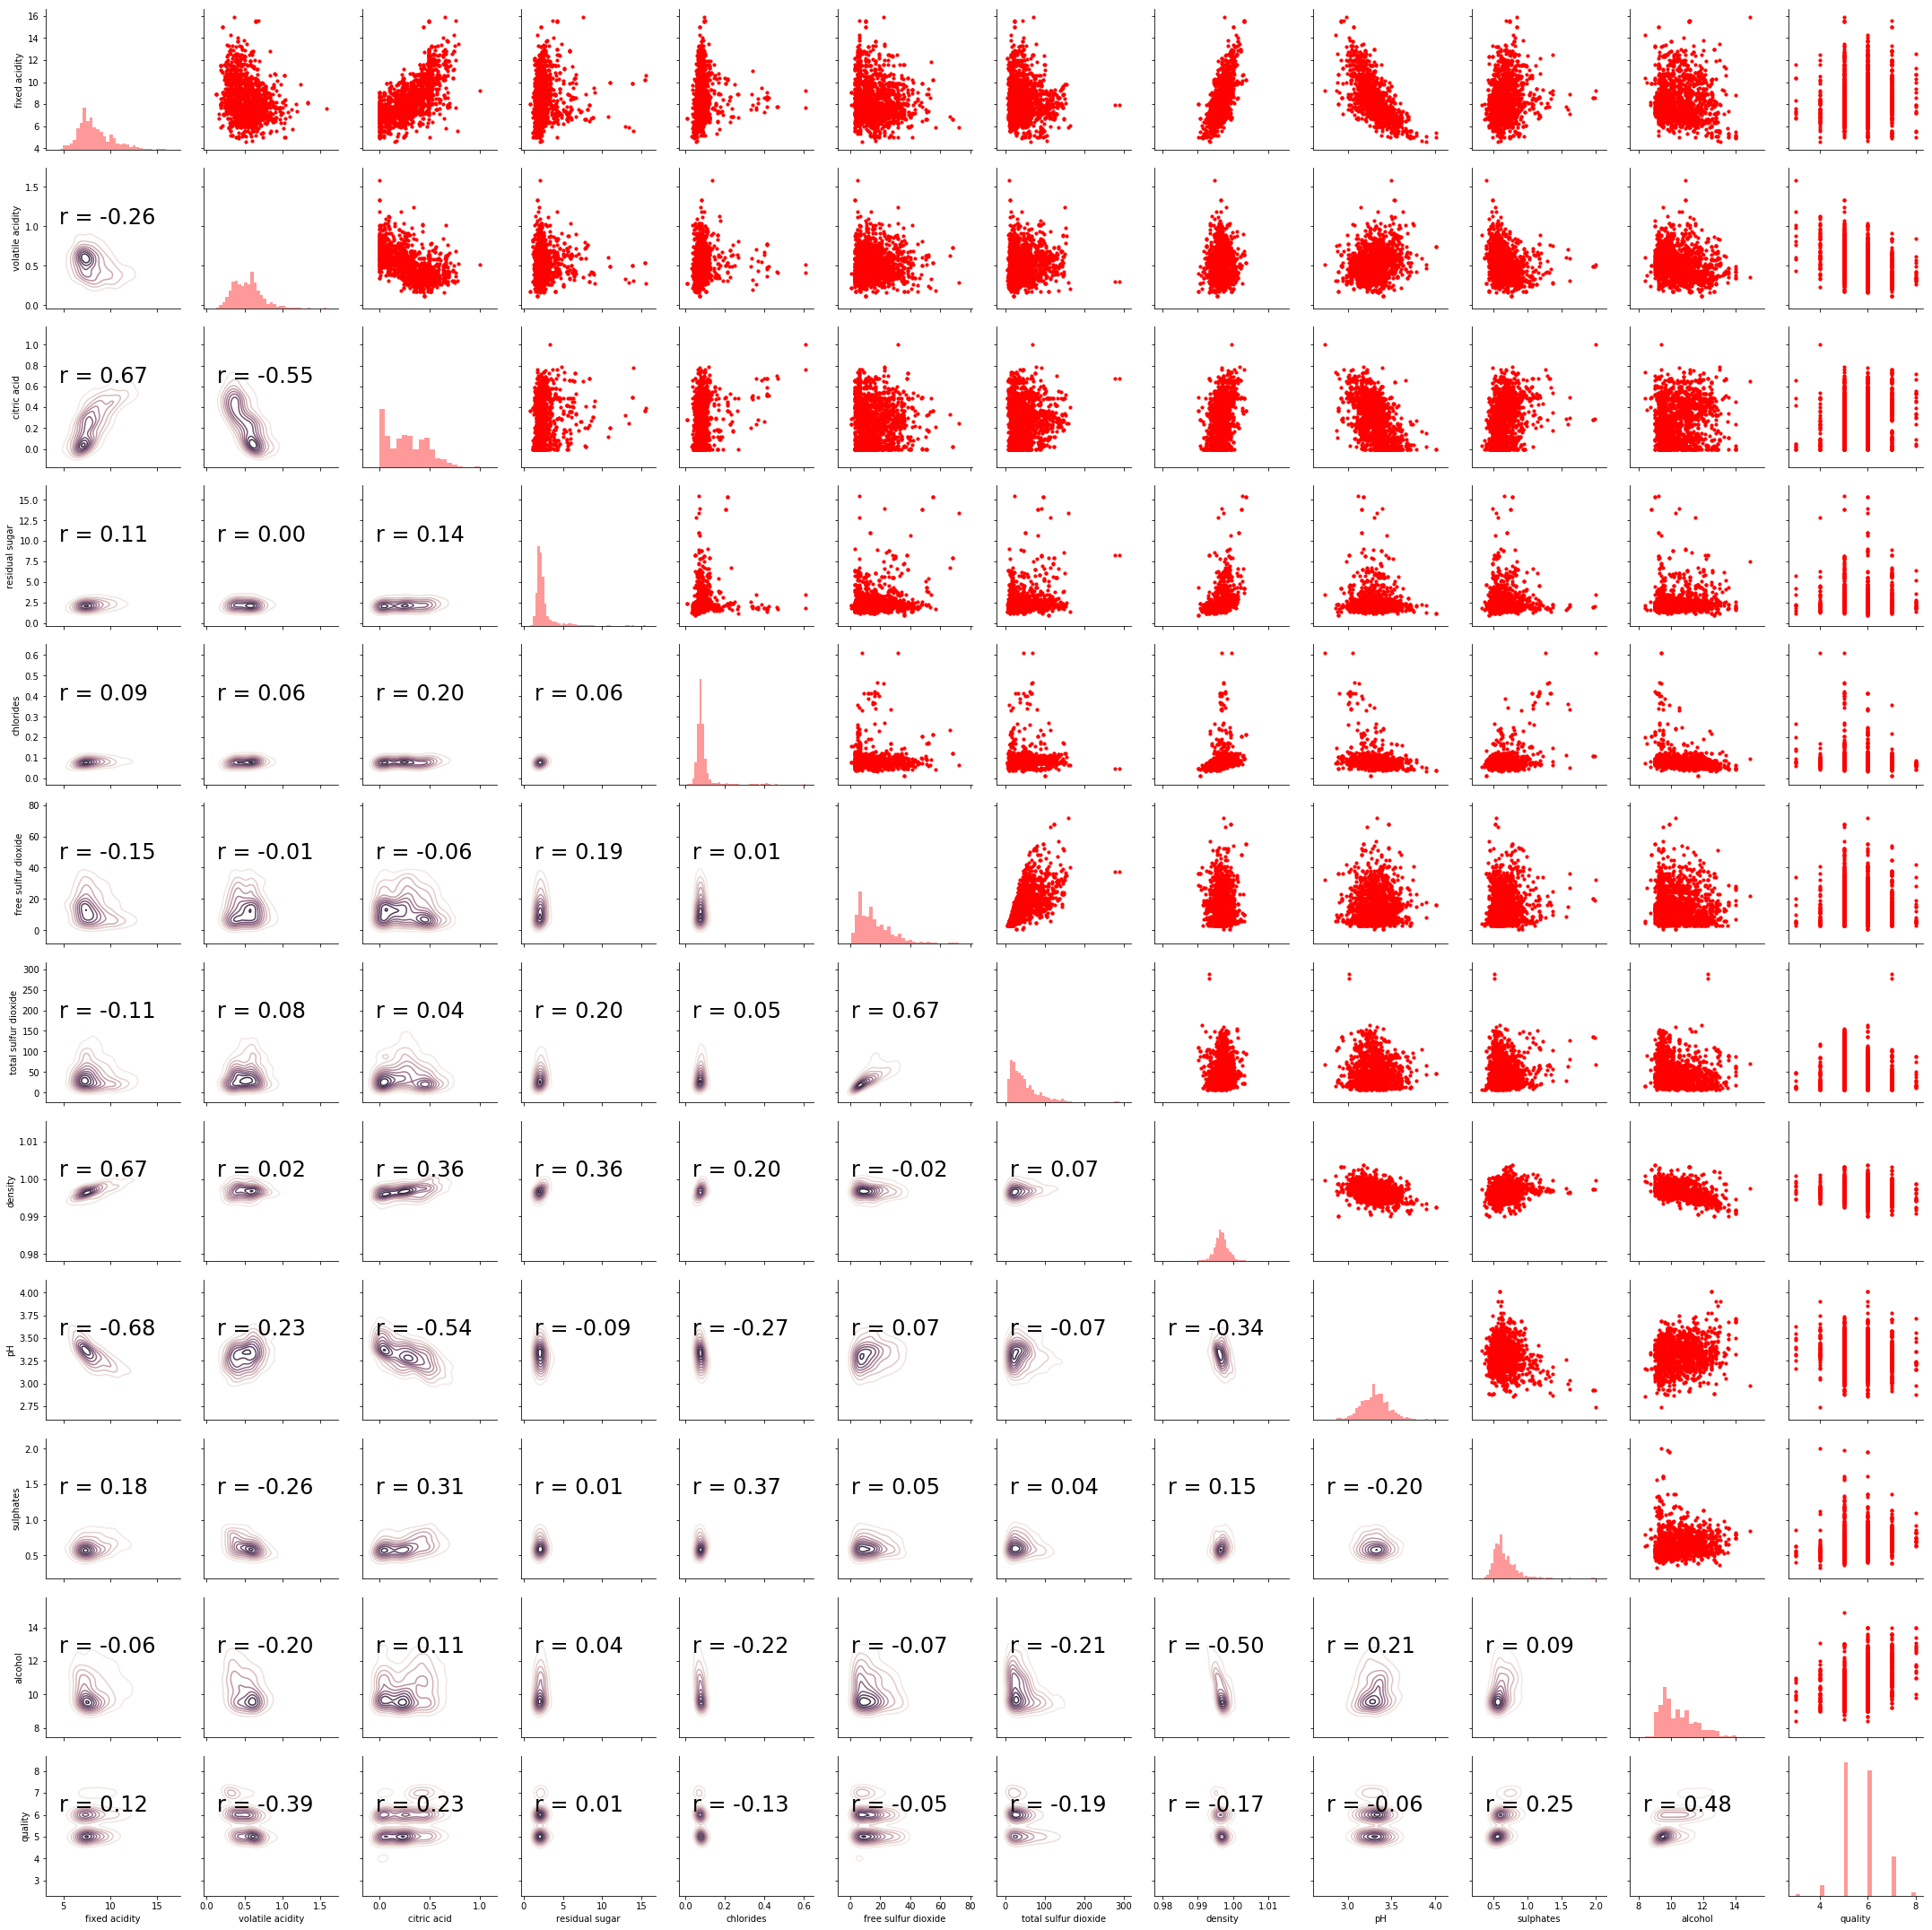

In [12]:
#Data Processing
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from scipy import stats
wineShuffle = wine.sample(frac=1)


def corrfunc(x,y, **kws):
    r, _ = stats.pearsonr(x,y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r), xy = (.1, .6), xycoords=ax.transAxes, size = 24)
cmap = sns.cubehelix_palette(light=1, dark = 0.1, hue = 0.5, as_cmap=True)
sns.set_context(font_scale = 2)

g = sns.PairGrid(wineShuffle)

g.map_upper(plt.scatter, s = 10, color = 'red')
g.map_diag(sns.distplot, kde=False, color = 'red')

g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

In [ ]:
#Data Processing
def partition(fmatrix, tvector, t):
    
    
    